## Imports

In [1]:
# sktime
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.compose import MultiplexForecaster, AutoEnsembleForecaster, ColumnEnsembleForecaster, DirRecTabularRegressionForecaster, RecursiveTabularRegressionForecaster, DirRecTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster, DirectTimeSeriesRegressionForecaster, EnsembleForecaster, StackingForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.compose import ColumnwiseTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler

from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteScaledError, mean_absolute_percentage_error, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, LassoLars, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, OrthogonalMatchingPursuit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgbm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
from functions import *

## Read Data

In [6]:
dataset_name = 'Satellite'
data, seasonal_period, freq_sktime = read_file(dataset_name, data_path='G:/My Drive/PhD/ECOSCOPE/time-series-forecasting-waves/data/')

Column 'date' was removed from Satellite.


In [7]:
data

,sla,ugosa,vgosa,err_ugosa,err_vgosa,adt,ugos,vgos
datetime,,,,,,,,
1993-01-01,-0.000316,-0.042639,0.021684,0.032655,0.038690,0.329958,-0.034710,0.005781
1993-02-01,-0.025014,-0.027007,-0.034014,0.033504,0.038207,0.305261,-0.019082,-0.049918
1993-03-01,-0.039558,0.022274,0.010235,0.032903,0.038090,0.290710,0.030203,-0.005668
1993-04-01,-0.062297,-0.057400,-0.029813,0.032583,0.038300,0.267980,-0.049467,-0.045723
1993-05-01,-0.045255,0.090942,-0.016448,0.032358,0.038768,0.285023,0.098865,-0.032352
...,...,...,...,...,...,...,...,...
2020-08-01,0.081081,-0.167006,0.030768,0.031016,0.036342,0.411352,-0.159061,0.014868
2020-09-01,0.109623,-0.083850,0.042430,0.030990,0.036527,0.439900,-0.075940,0.026523
2020-10-01,0.137674,0.044274,-0.005913,0.030810,0.036587,0.467961,0.052197,-0.021819


## Initializations

In [25]:
forecasters = {
    'naive_forecaster': {
        'estimator': 
            NaiveForecaster(sp=1, strategy='last', window_length=None)
        ,  
    },    
    'naive_forecaster_seasonal': {
        'estimator': 
            NaiveForecaster(sp=12, strategy='last', window_length=None)
        ,  
    },
    'polynomial_trend_forecaster': {
        'estimator': 
            PolynomialTrendForecaster(degree=1, regressor=None, with_intercept=True)
        ,  
    },    
    'arima': {
        'estimator': 
            AutoARIMA(n_jobs=-1)
        ,  
    },    
    'exponential_smoothing': {
        'estimator': 
            ExponentialSmoothing(damped_trend=False, initial_level=None, initial_seasonal=None, initial_trend=None, initialization_method='estimated', seasonal=None, sp=seasonal_period, trend='add', use_boxcox=None)
        ,  
    },    
    'ets': {
        'estimator': 
            AutoETS(n_jobs=-1)
        ,  
    },      
    'theta_forecaster': {
        'estimator': 
            ThetaForecaster(deseasonalize=True, initial_level=None, sp=seasonal_period)
        ,  
    },     
    'decision_tree': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=DecisionTreeRegressor(ccp_alpha=0.0,  criterion='mse', max_depth=None, max_features=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, 
                                  min_weight_fraction_leaf=0.0, random_state=42, splitter='best'))
        ,  
    },
    'random_forest': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse', max_depth=None, max_features='auto', 
                                  max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                  min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, 
                                  n_jobs=-1, oob_score=False, random_state=42, verbose=0, warm_start=False))
        ,   
    },    
    'extra_trees': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse', max_depth=None, max_features='auto', 
                                max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, 
                                n_jobs=-1, oob_score=False, random_state=42, verbose=0, warm_start=False))
        ,    
    },     
    'gradient_boosting': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.1, loss='ls', 
                                      max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                      min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, 
                                      random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))
        ,   
    },       
    'adaboost': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear', n_estimators=50, random_state=42))
        ,  
    },      
    'lgb_regressor': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=lgbm.sklearn.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, 
                                       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, 
                                       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0))
        ,    
    },   
    'knn': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2, weights='uniform'))
        ,    
    },    
    'passive_aggressive': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False, epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive', max_iter=1000, 
                                       n_iter_no_change=5, random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))
        ,    
    },       
    'huber': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100, tol=1e-05, warm_start=False))
        ,    
    },     
    'bayesian_ridge': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-06, 
                          lambda_2=1e-06, lambda_init=None, n_iter=300, normalize=False, tol=0.001, verbose=False))
        ,    
    },        
    'lasso_lars': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True, jitter=None, max_iter=500, 
                      normalize=True, positive=False, precompute='auto', random_state=42, verbose=False))
        ,   
    },        
    'lars': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True, jitter=None, n_nonzero_coefs=500, 
                 normalize=True, precompute='auto', random_state=42, verbose=False))
        ,     
    },       
    'elastic_net': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5, max_iter=1000, normalize=False, positive=False, 
                       precompute=False, random_state=42, selection='cyclic', tol=0.0001, warm_start=False))
        ,    
    },        
    'ridge': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=42, solver='auto', tol=0.001))
        ,    
    },     
    'lasso': {
        'estimator': 
            DirectTabularRegressionForecaster(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False, positive=False, precompute=False, 
                  random_state=42, selection='cyclic', tol=0.0001, warm_start=False))
        ,    
    },        
}
ML_forecasters = ['decision_tree', 'random_forest', 'extra_trees', 'gradient_boosting', 'adaboost', 'lgb_regressor', 
                  'knn', 'passive_aggressive', 'huber', 'bayesian_ridge' , 'lasso_lars', 'lars', 'elastic_net', 
                  'ridge', 'lasso']

## Modeling

### Train - Valid -- No Preprocess -- No Tuning

In [31]:
# define forecastin horizon
fh = 12
fh=[i+1 for i in range (fh)]

# Read Data
dataset_name = 'Satellite'
data, seasonal_period, freq_sktime = read_file(dataset_name, data_path='G:/My Drive/PhD/ECOSCOPE/time-series-forecasting-waves/data/')
preprocess = False

# ONLY FOR SKTIME
# keep datetime as a column for plots
data['datetime'] = data.index
data.index = pd.PeriodIndex(data.index, freq=freq_sktime)

for target in data.drop(columns=['datetime']).columns[:1]:
    print('#'*70, target, '#'*70)
    
    # split data
    train, test, valid, train_without_valid, train_test_split_date, train_valid_split_date = train_valid_test_split(dataset_name, data)
    initial_window = train_without_valid.shape[0]
    
    # save prediction in a df. a column per method
    predictions_valid = pd.DataFrame()
    predictions_valid['datetime'] = valid['datetime']
    predictions_valid['true_values'] = valid[target]

    # define metrics
    rmse = MeanSquaredError(square_root=True)
    mase = MeanAbsoluteScaledError(sp=seasonal_period)
    smape = mean_absolute_percentage_error
    mae = MeanAbsoluteError()
    # keep track of scores, per method and fh
    scores_expanding = pd.DataFrame()

    for forecaster_name, value in forecasters.items():
        forecaster = value['estimator']
        # if ML forecaster
        if forecaster_name in ML_forecasters:
            window_tuned_model = pd.read_pickle(f'../results/tuned_models/just_window/{dataset_name}/{target}.{forecaster_name}.pkl')
            window_length = window_tuned_model.get_params()['forecaster'].get_params()['window_length']
            forecaster = forecaster.set_params(window_length=window_length)
        
        print('='*40, forecaster, '='*40)
        min_max_scaler = TabularToSeriesAdaptor(MinMaxScaler(feature_range=(1, 2)))
        pipe = TransformedTargetForecaster(steps=[
            # ("detrender", Detrender()),
            # ("deseasonalizer", Differencer(lags=1)),
            ("minmaxscaler", min_max_scaler),
            ("forecaster", forecaster),
        ])

        df = evaluate_sktime(pipe, train[target], fh=fh, initial_window=initial_window, 
                             metrics=['MAE', 'RMSE', 'sMAPE', 'MASE'], seasonal_period=seasonal_period)

        # save predictions in a df
        for ii in fh:
            forecasts = []
            for v in df['y_pred'].values:
                try:
                    forecasts.append(v.values[ii-1])
                except IndexError:
                    pass
            if ii < np.max(fh):
                for i in range(len(predictions_valid)-len(forecasts)-ii+1):
                    forecasts.append(np.nan)
            for i in range(ii-1):
                forecasts = np.insert(forecasts, 0, np.nan)
            predictions_valid[f'fh={ii} {forecaster}'] = forecasts
        
        total_runtime = np.sum(df['fit_time']) + np.sum(df['pred_time'])
        
        # evaluate forecasting horizons on the same number of samples
        p = predictions_valid.dropna()
        
        scores_expanding = scores_expanding.append({
            'Method': str(forecaster).replace('\n', '').replace(' ', ''), 
            'Forecasting Horizon': fh, 
            'Preprocess': preprocess,
            'Runtime': total_runtime,      
            
        }, ignore_index=True)
        
        for i in fh:
            maes, rmses, smapes, mases = [], [], [], []
            for ii, (j, row) in enumerate(p.iterrows()):
                maes.append(mae([row['true_values']], [row[f'fh={i} {forecaster}']]))
                rmses.append(rmse([row['true_values']], [row[f'fh={i} {forecaster}']]))
                smapes.append(smape([row['true_values']], [row[f'fh={i} {forecaster}']]))
                mases.append(mase([row['true_values']], [row[f'fh={i} {forecaster}']], y_train=df.iloc[max(fh)-1+ii]['y_train']))
            
            
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} MAE'] = np.mean(maes)   
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} RMSE'] = np.mean(rmses) 
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} sMAPE'] = np.mean(smapes) 
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} MASE'] = np.mean(mases) 
            
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} MAE std'] = np.std(maes)   
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} RMSE std'] = np.std(rmses) 
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} sMAPE std'] = np.std(smapes) 
            scores_expanding.at[scores_expanding.index.max(), f'fh={i} MASE std'] = np.std(mases) 
            
    predictions_valid.to_csv(f'../results/predictions/valid/no_preprocess/{dataset_name}/{target}.csv', index=False)
    scores_expanding.to_csv(f'../results/scores/valid/no_preprocess/{dataset_name}/{target}.csv', index=False)

Column 'date' was removed from Satellite.
###################################################################### sla ######################################################################
train datetime margins              : 1993-01 - 2017-12.     Total samples: 300 (89.3%)
test datetime margins               : 2018-01 - 2020-12.     Total samples: 36 (10.7%)
valid datetime margins              : 2015-01 - 2017-12.     Total samples: 36 (10.7%)
train_without_valid datetime margins: 1993-01 - 2014-12.     Total samples: 264 (78.6%)
======================================== NaiveForecaster() ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 20.70it/s]


======================================== NaiveForecaster(sp=12) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 21.31it/s]


======================================== PolynomialTrendForecaster() ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 20.22it/s]


======================================== AutoARIMA(n_jobs=-1) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [03:29<00:00,  5.81s/it]


======================================== ExponentialSmoothing(sp=12, trend='add') ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 12.04it/s]


======================================== AutoETS(n_jobs=-1) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.50it/s]


======================================== ThetaForecaster(sp=12) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 15.90it/s]


======================================== DirectTabularRegressionForecaster(estimator=DecisionTreeRegressor(random_state=42),
                                  window_length=18) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00, 10.96it/s]


======================================== DirectTabularRegressionForecaster(estimator=RandomForestRegressor(n_jobs=-1,
                                                                  random_state=42),
                                  window_length=24) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [02:48<00:00,  4.67s/it]


======================================== DirectTabularRegressionForecaster(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=42),
                                  window_length=48) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:58<00:00,  3.30s/it]


======================================== DirectTabularRegressionForecaster(estimator=GradientBoostingRegressor(random_state=42),
                                  window_length=30) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:33<00:00,  2.59s/it]


======================================== DirectTabularRegressionForecaster(estimator=AdaBoostRegressor(random_state=42),
                                  window_length=30) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.70s/it]


======================================== DirectTabularRegressionForecaster(estimator=LGBMRegressor(random_state=42),
                                  window_length=24) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.11it/s]


======================================== DirectTabularRegressionForecaster(estimator=KNeighborsRegressor(n_jobs=-1),
                                  window_length=18) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:53<00:00,  1.47s/it]


======================================== DirectTabularRegressionForecaster(estimator=PassiveAggressiveRegressor(random_state=42),
                                  window_length=24) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.66it/s]


======================================== DirectTabularRegressionForecaster(estimator=HuberRegressor(), window_length=24) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:15<00:00,  2.31it/s]


======================================== DirectTabularRegressionForecaster(estimator=BayesianRidge(), window_length=12) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 15.58it/s]


======================================== DirectTabularRegressionForecaster(estimator=LassoLars(random_state=42),
                                  window_length=48) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 16.49it/s]


======================================== DirectTabularRegressionForecaster(estimator=Lars(random_state=42),
                                  window_length=18) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00, 10.27it/s]


======================================== DirectTabularRegressionForecaster(estimator=ElasticNet(random_state=42),
                                  window_length=48) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.33it/s]


======================================== DirectTabularRegressionForecaster(estimator=Ridge(random_state=42),
                                  window_length=12) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.17it/s]


======================================== DirectTabularRegressionForecaster(estimator=Lasso(random_state=42),
                                  window_length=48) ========================================


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.37it/s]


In [32]:
scores_expanding

,Method,Forecasting Horizon,Preprocess,Runtime,fh=1 MAE,fh=1 RMSE,fh=1 sMAPE,fh=1 MASE,fh=1 MAE std,fh=1 RMSE std,...,fh=11 sMAPE std,fh=11 MASE std,fh=12 MAE,fh=12 RMSE,fh=12 sMAPE,fh=12 MASE,fh=12 MAE std,fh=12 RMSE std,fh=12 sMAPE std,fh=12 MASE std
0,NaiveForecaster(),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,0.427932,0.019741,0.019741,0.298817,0.772762,0.013292,0.013292,...,0.377617,0.671159,0.027695,0.027695,0.459969,1.083508,0.019279,0.019279,0.384934,0.756575
1,NaiveForecaster(sp=12),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,0.435405,0.027695,0.027695,0.459969,1.083508,0.019279,0.019279,...,0.384934,0.756575,0.027695,0.027695,0.459969,1.083508,0.019279,0.019279,0.384934,0.756575
2,PolynomialTrendForecaster(),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,0.310285,0.027413,0.027413,0.371660,1.071057,0.017234,0.017234,...,0.262707,0.678679,0.027603,0.027603,0.373759,1.078487,0.017467,0.017467,0.264500,0.683408
3,AutoARIMA(n_jobs=-1),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,207.827015,0.020233,0.020233,0.309447,0.791673,0.011970,0.011970,...,0.301508,0.685753,0.029365,0.029365,0.418258,1.147525,0.018165,0.018165,0.311599,0.710891
4,"ExponentialSmoothing(sp=12,trend='add')","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,1.738252,0.019699,0.019699,0.297831,0.771100,0.013386,0.013386,...,0.368774,0.643262,0.027617,0.027617,0.448030,1.080294,0.019008,0.019008,0.377697,0.745601
5,AutoETS(n_jobs=-1),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,0.662847,0.019741,0.019741,0.298811,0.772755,0.013292,0.013292,...,0.377569,0.671134,0.027694,0.027694,0.459934,1.083466,0.019279,0.019279,0.384869,0.756570
6,ThetaForecaster(sp=12),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,0.755593,0.021744,0.021744,0.377364,0.848953,0.018503,0.018503,...,0.330917,0.609318,0.025358,0.025358,0.457078,0.990933,0.018243,0.018243,0.424673,0.712976
7,DirectTabularRegressionForecaster(estimator=De...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,2.067062,0.032227,0.032227,0.607777,1.259024,0.022516,0.022516,...,0.531698,1.031575,0.036480,0.036480,0.782978,1.426357,0.028390,0.028390,0.706826,1.108931
8,DirectTabularRegressionForecaster(estimator=Ra...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,166.847876,0.018947,0.018947,0.293875,0.741249,0.012004,0.012004,...,0.259178,0.682377,0.028936,0.028936,0.473523,1.131996,0.019080,0.019080,0.342212,0.749159
9,DirectTabularRegressionForecaster(estimator=Ex...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.0,117.331808,0.018295,0.018295,0.289971,0.715564,0.012050,0.012050,...,0.312109,0.691599,0.024286,0.024286,0.390188,0.949827,0.018425,0.018425,0.324696,0.722742


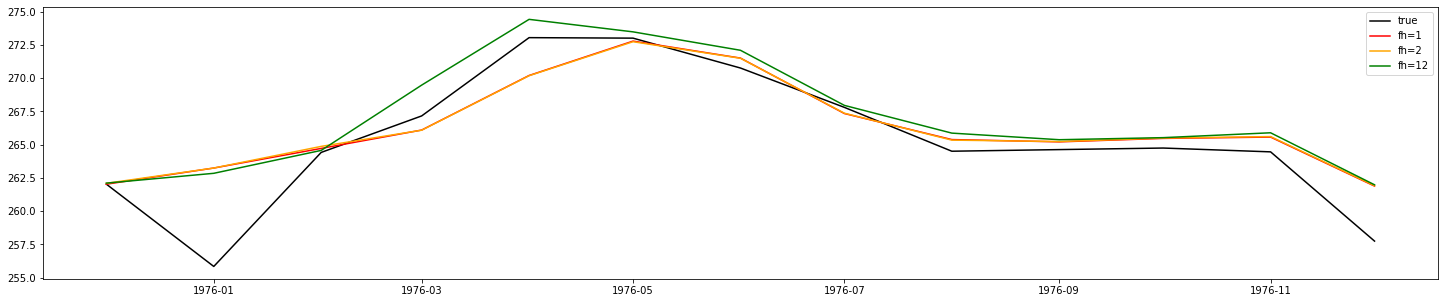

In [13]:
fig, ax = plt.subplots(figsize=(25,5))
plt.plot(p['datetime'], p['true_values'], label='true', color='black')
plt.plot(p['datetime'], p["fh=1 ThetaForecaster(sp=12)"], label='fh=1', color='red')
plt.plot(p['datetime'], p["fh=2 ThetaForecaster(sp=12)"], label='fh=2', color='orange')
plt.plot(p['datetime'], p["fh=12 ThetaForecaster(sp=12)"], label='fh=12', color='green')
plt.legend();